In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# DBSCAN import
from sklearn.cluster import DBSCAN

# Scaler import
from sklearn.preprocessing import MinMaxScaler

import env

### add csv to gitignor

Use DBSCAN to detect anomalies in curriculumn access. 

Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [2]:
def get_curriculum_logs():
    filename = "curriculum-access.csv"

    if os.path.isfile(filename):
        return pd.read_csv(filename, index_col=False)
    else:
        # read the SQL query into a dataframe
        url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
        query = '''
        SELECT date,
               path as endpoint,
               user_id,
               cohort_id,
               ip as source_ip
        FROM logs;
        '''
        df = pd.read_sql(query, url)

        # Write that dataframe to disk for later.
        df.to_csv(filename, index = False)

        return df  

In [3]:
df = get_curriculum_logs()
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [4]:
page_views = df.groupby(['user_id'])['endpoint'].agg(['count', 'nunique'])
page_views

,count,nunique
user_id,,
1,7404,976
2,1541,151
3,1562,169
4,692,143
5,1701,197
...,...,...
977,86,12
978,55,18
979,127,20


In [5]:
# create the scaler
scaler = MinMaxScaler().fit(page_views)
# use the scaler
page_views_scaled_array = scaler.transform(page_views)
page_views_scaled_array[0:10]

array([[0.41329835, 1.        ],
       [0.08597588, 0.15384615],
       [0.08714828, 0.17230769],
       [0.03857749, 0.14564103],
       [0.09490844, 0.20102564],
       [0.07855069, 0.22974359],
       [0.10060295, 0.17435897],
       [0.02690933, 0.09128205],
       [0.03260384, 0.14871795],
       [0.05141804, 0.14666667]])

In [6]:
#981 users
page_views.shape

(981, 2)

In [7]:
# will play with these values for the exercise

dbsc = DBSCAN(eps = 0.1, min_samples=10).fit(page_views_scaled_array)
print(dbsc)

DBSCAN(eps=0.1, min_samples=10)


In [8]:
columns = list(page_views.columns)
scaled_columns = ["scaled_" + column for column in columns]
scaled_columns

['scaled_count', 'scaled_nunique']

In [9]:
scaled_df = pd.DataFrame(page_views_scaled_array, columns=scaled_columns, index=page_views.index)
scaled_df.head()

,scaled_count,scaled_nunique
user_id,,
1,0.413298,1.000000
2,0.085976,0.153846
3,0.087148,0.172308
4,0.038577,0.145641
5,0.094908,0.201026


In [10]:
page_views.head()

,count,nunique
user_id,,
1,7404,976
2,1541,151
3,1562,169
4,692,143
5,1701,197


In [11]:
# Merge the scaled and non-scaled values into one dataframe
page_views = page_views.merge(scaled_df, left_index=True, right_index=True)
page_views

,count,nunique,scaled_count,scaled_nunique
user_id,,,,
1,7404,976,0.413298,1.000000
2,1541,151,0.085976,0.153846
3,1562,169,0.087148,0.172308
4,692,143,0.038577,0.145641
5,1701,197,0.094908,0.201026
...,...,...,...,...
977,86,12,0.004745,0.011282
978,55,18,0.003015,0.017436
979,127,20,0.007034,0.019487


In [12]:
labels = dbsc.labels_
labels[0:15]

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0])

In [13]:
#add labels back to the dataframe
page_views['labels'] = labels

# how many unique labels (clusters) are created by DBSCAN?
page_views.labels.value_counts()

 0    973
-1      8
Name: labels, dtype: int64

In [14]:
page_views[page_views.labels==-1]

,count,nunique,scaled_count,scaled_nunique,labels
user_id,,,,,
1,7404,976,0.413298,1.000000,-1
11,17913,871,1.000000,0.892308,-1
53,12329,333,0.688254,0.340513,-1
64,16347,437,0.912573,0.447179,-1
248,5075,625,0.283274,0.640000,-1
314,7783,225,0.434457,0.229744,-1
495,6451,243,0.360094,0.248205,-1
581,6434,354,0.359145,0.362051,-1


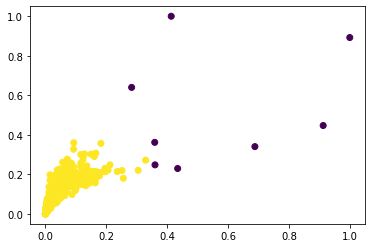

In [15]:
plt.scatter(page_views['scaled_count'], page_views['scaled_nunique'], c=page_views.labels)
plt.show()

In [16]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
query = '''
SELECT date, time, path, user_id, cohort_id, program_id, ip, name, slack, start_date, end_date, created_at, updated_at
FROM logs
JOIN cohorts on logs.cohort_id = cohorts.id
'''
df= pd.read_sql(query, url)
df.head()

,date,time,path,user_id,cohort_id,program_id,ip,name,slack,start_date,end_date,created_at,updated_at
0,2018-01-26,09:55:03,/,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
1,2018-01-26,09:56:02,java-ii,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,2,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10


In [17]:
df.count()

date          847330
time          847330
path          847329
user_id       847330
cohort_id     847330
program_id    847330
ip            847330
name          847330
slack         847330
start_date    847330
end_date      847330
created_at    847330
updated_at    847330
dtype: int64

In [18]:
df1 = df

In [19]:
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)

In [20]:
df.head()

,date,time,path,user_id,cohort_id,program_id,ip,name,slack,start_date,end_date,created_at,updated_at
date,,,,,,,,,,,,,
2018-01-26,2018-01-26,09:55:03,/,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
2018-01-26,2018-01-26,09:56:02,java-ii,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
2018-01-26,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
2018-01-26,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,1,97.105.19.61,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26
2018-01-26,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,2,97.105.19.61,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10


In [21]:
df.dtypes

date          datetime64[ns]
time                  object
path                  object
user_id                int64
cohort_id            float64
program_id             int64
ip                    object
name                  object
slack                 object
start_date            object
end_date              object
created_at            object
updated_at            object
dtype: object

In [22]:
page_views = df.groupby(['user_id'])['path'].agg(['count', 'nunique'])
page_views

,count,nunique
user_id,,
1,7404,976
2,1541,151
3,1562,169
4,692,143
5,1701,197
...,...,...
977,86,12
978,55,18
979,127,20


In [23]:
# create the scaler
scaler = MinMaxScaler().fit(page_views)
# use the scaler
page_views_scaled_array = scaler.transform(page_views)
page_views_scaled_array[0:10]

array([[0.41329835, 1.        ],
       [0.08597588, 0.15384615],
       [0.08714828, 0.17230769],
       [0.03857749, 0.14564103],
       [0.09490844, 0.20102564],
       [0.07855069, 0.22974359],
       [0.10060295, 0.17435897],
       [0.02690933, 0.09128205],
       [0.03260384, 0.14871795],
       [0.05141804, 0.14666667]])

In [24]:
dbsc = DBSCAN(eps = 0.1, min_samples=4).fit(page_views_scaled_array)
print(dbsc)

DBSCAN(eps=0.1, min_samples=4)


In [25]:
columns = list(page_views.columns)
scaled_columns = ["scaled_" + column for column in columns]
scaled_columns

['scaled_count', 'scaled_nunique']

In [26]:
scaled_df = pd.DataFrame(page_views_scaled_array, columns=scaled_columns, index=page_views.index)
scaled_df.head()

,scaled_count,scaled_nunique
user_id,,
1,0.413298,1.000000
2,0.085976,0.153846
3,0.087148,0.172308
4,0.038577,0.145641
5,0.094908,0.201026


In [27]:
page_views.head()

,count,nunique
user_id,,
1,7404,976
2,1541,151
3,1562,169
4,692,143
5,1701,197


In [28]:
labels = dbsc.labels_

In [29]:
labels[0:15]

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0])

In [30]:
#add labels back to the dataframe
page_views['labels'] = labels

# how many unique labels (clusters) are created by DBSCAN?
page_views.labels.value_counts()

 0    906
-1      5
Name: labels, dtype: int64

In [31]:
#lets look at those outliers - 
page_views[page_views.labels==-1]

,count,nunique,labels
user_id,,,
1,7404,976,-1
11,17913,871,-1
53,12329,333,-1
64,16322,436,-1
248,5075,625,-1


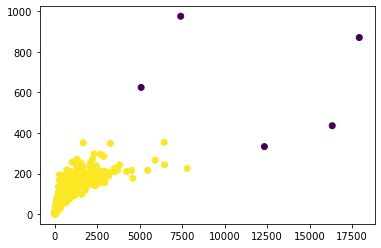

In [33]:
#non scaled
plt.scatter(page_views['count'], page_views['nunique'], c=page_views.labels)
plt.show()